In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import string
from bs4 import BeautifulSoup
import json
import numpy as np

In [2]:
with open("/content/drive/MyDrive/Sarcasm-Detector/Sarcasm.json",'r') as input:
  data = json.load(input)
print(len(data))

26709


In [3]:
## Use NLTK's Stopword List
import nltk
from nltk.corpus import stopwords

nltk.download("stopwords")
stopwords = stopwords.words("english")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
sarcasm_sentences = []
labels = []
links = []
punctuations = str.maketrans('', '', string.punctuation)
for item in data:
  sentence = item['headline'].lower()
  sentence = sentence.replace(",", " , ").replace(".", " . ").replace("-", " - ").replace("/", " / ")
  sentence = BeautifulSoup(sentence, "html.parser").get_text()

  words = sentence.split()
  filtered_sentence = ""

  for word in words:
    word = word.translate(punctuations)
    if word not in stopwords:
      filtered_sentence += word + " "
  sarcasm_sentences.append(filtered_sentence)
  labels.append(item['is_sarcastic'])
  links.append(item['article_link'])

In [5]:
print(len(sarcasm_sentences))

26709


In [6]:
training_size = 20000
vocab_size = 20000
maxlen = 40
training_sentences = sarcasm_sentences[0:training_size]
training_labels = labels[0:training_size]
testing_sentences = sarcasm_sentences[training_size:]
testing_labels = labels[training_size:]

In [7]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
training_sequence = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequence, maxlen=maxlen, padding='post', truncating='post')
testing_sequence = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequence, maxlen=maxlen, padding='post', truncating='post')

In [8]:
import numpy as np
training_padded = np.array(training_padded)
training_labels = np.array(training_labels).astype(np.float32).reshape(-1)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels).astype(np.float32).reshape(-1)

In [9]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_accuracy',   # You can also monitor 'val_accuracy'
    patience=10,           # Stop after 10 epochs of no improvement
    restore_best_weights=True
)


In [10]:
model = tf.keras.Sequential([
          tf.keras.layers.Embedding(input_dim=20000, output_dim=64, input_length=maxlen),
          tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=False)),
          tf.keras.layers.Dense(32, activation='relu'),
          tf.keras.layers.Dense(1, activation='sigmoid')
        ])
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy']
              )
model.build(input_shape=(None, maxlen))

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 40, 64)         │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,350,209 (5.15 MB)

 Trainable params: 1,350,209 (5.15 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
history = model.fit(training_padded, training_labels,
                    epochs=30,
                    validation_data=(testing_padded, testing_labels),
                    callbacks=[early_stop]
                  )

Epoch 1/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.6877 - loss: 0.5593 - val_accuracy: 0.8109 - val_loss: 0.4215
Epoch 2/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.9131 - loss: 0.2205 - val_accuracy: 0.8094 - val_loss: 0.4384
Epoch 3/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.9664 - loss: 0.0978 - val_accuracy: 0.7985 - val_loss: 0.5588
Epoch 4/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.9850 - loss: 0.0457 - val_accuracy: 0.7861 - val_loss: 0.8331
Epoch 5/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9922 - loss: 0.0228 - val_accuracy: 0.7869 - val_loss: 0.8968
Epoch 6/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.9956 - loss: 0.0175 - val_accuracy: 0.7818 - val_loss: 1.0775
Epoch 7/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9975 - loss: 0.0088 - val_accuracy: 0.7776 - val_loss: 1.3253
Epoch 8/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.9982 - loss: 0.0056 - val_accu

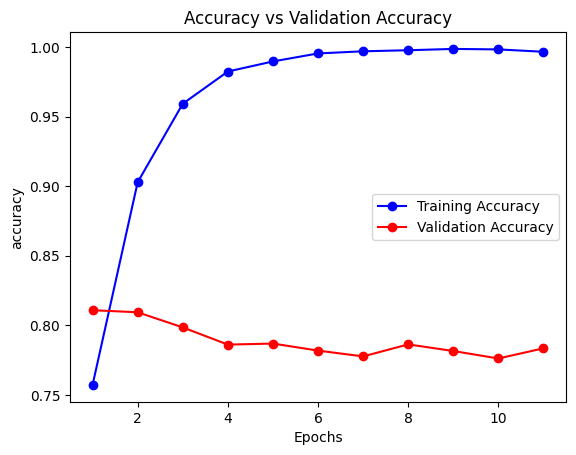

In [12]:
## plotting accuracy vs validation accuracy
import matplotlib.pyplot as plt

def plot_accuracy(history):
  acc = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']
  epochs = range(1, len(acc) + 1)
  plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
  plt.plot(epochs, val_accuracy, 'ro-', label='Validation Accuracy')
  plt.title("Accuracy vs Validation Accuracy")
  plt.legend()
  plt.xlabel('Epochs')
  plt.ylabel('accuracy')
  plt.show()
plot_accuracy(history)

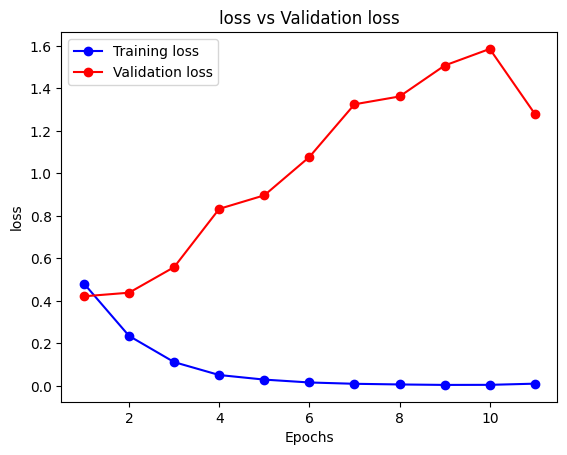

In [13]:
## plotting loss vs validation loss
import matplotlib.pyplot as plt

def plot_accuracy(history):
  acc = history.history['loss']
  val_accuracy = history.history['val_loss']
  epochs = range(1, len(acc) + 1)
  plt.plot(epochs, acc, 'bo-', label='Training loss')
  plt.plot(epochs, val_accuracy, 'ro-', label='Validation loss')
  plt.title("loss vs Validation loss")
  plt.legend()
  plt.xlabel('Epochs')
  plt.ylabel('loss')
  plt.show()
plot_accuracy(history)

## Reducing Overfitting in Language Models

In [14]:
## Adjusting the learning rate
from tensorflow.keras.optimizers import Adam
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.00001,beta_1=0.90, beta_2=0.999, amsgrad=False),
              metrics=['accuracy']
              )
history1 = model.fit(training_padded, training_labels,
                    epochs=30,
                    validation_data=(testing_padded, testing_labels),
                    callbacks=[early_stop]
                  )

Epoch 1/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.9251 - loss: 0.2371 - val_accuracy: 0.8137 - val_loss: 0.4150
Epoch 2/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9290 - loss: 0.1990 - val_accuracy: 0.8106 - val_loss: 0.4304
Epoch 3/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.9250 - loss: 0.1925 - val_accuracy: 0.8101 - val_loss: 0.4425
Epoch 4/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.9298 - loss: 0.1848 - val_accuracy: 0.8119 - val_loss: 0.4489
Epoch 5/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9329 - loss: 0.1791 - val_accuracy: 0.8125 - val_loss: 0.4541
Epoch 6/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.9352 - loss: 0.1714 - val_accuracy: 0.8122 - val_loss: 0.4575
Epoch 7/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9331 - loss: 0.1750 - val_accuracy: 0.8135 - val_loss: 0.4623
Epoch 8/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.9382 - loss: 0.1650 - val_acc

In [15]:
## Exploring embedding dimensions
model = tf.keras.Sequential([
          tf.keras.layers.Embedding(input_dim=20000, output_dim=32, input_length=maxlen),
          tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=False)),
          tf.keras.layers.Dense(32, activation='relu'),
          tf.keras.layers.Dense(1, activation='sigmoid')
        ])

model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.0001,beta_1=0.90, beta_2=0.999, amsgrad=False),
              metrics=['accuracy']
              )

history2 = model.fit(training_padded, training_labels,
                    epochs=30,
                    validation_data=(testing_padded, testing_labels),
                    callbacks=[early_stop]
                  )

Epoch 1/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.5638 - loss: 0.6825 - val_accuracy: 0.6508 - val_loss: 0.6238
Epoch 2/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.7448 - loss: 0.5273 - val_accuracy: 0.7946 - val_loss: 0.4443
Epoch 3/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.8621 - loss: 0.3308 - val_accuracy: 0.8000 - val_loss: 0.4316
Epoch 4/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.9006 - loss: 0.2458 - val_accuracy: 0.7906 - val_loss: 0.4502
Epoch 5/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9203 - loss: 0.2053 - val_accuracy: 0.8034 - val_loss: 0.4674
Epoch 6/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.9426 - loss: 0.1565 - val_accuracy: 0.8006 - val_loss: 0.5019
Epoch 7/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9568 - loss: 0.1250 - val_accuracy: 0.7973 - val_loss: 0.5366
Epoch 8/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.9629 - loss: 0.1063 - val_accu

In [16]:
## Using Dropout
model = tf.keras.Sequential([
          tf.keras.layers.Embedding(input_dim=20000, output_dim=32, input_length=maxlen),
          tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=False)),
          tf.keras.layers.Dropout(.25),
          tf.keras.layers.Dense(32, activation='relu'),
          tf.keras.layers.Dropout(.25),
          tf.keras.layers.Dense(1, activation='sigmoid')
        ])

model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.0001,beta_1=0.90, beta_2=0.999, amsgrad=False),
              metrics=['accuracy']
              )

history3 = model.fit(training_padded, training_labels,
                    epochs=30,
                    validation_data=(testing_padded, testing_labels),
                    callbacks=[early_stop]
                  )

Epoch 1/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.5491 - loss: 0.6868 - val_accuracy: 0.5962 - val_loss: 0.6511
Epoch 2/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.6929 - loss: 0.5968 - val_accuracy: 0.7715 - val_loss: 0.4751
Epoch 3/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.8351 - loss: 0.3839 - val_accuracy: 0.7888 - val_loss: 0.4488
Epoch 4/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.8811 - loss: 0.2961 - val_accuracy: 0.8025 - val_loss: 0.4375
Epoch 5/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9165 - loss: 0.2205 - val_accuracy: 0.7983 - val_loss: 0.4525
Epoch 6/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9306 - loss: 0.1853 - val_accuracy: 0.7992 - val_loss: 0.5062
Epoch 7/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.9499 - loss: 0.1487 - val_accuracy: 0.7989 - val_loss: 0.5185
Epoch 8/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.9595 - loss: 0.1241 - val_

In [17]:
## Using regularization
model = tf.keras.Sequential([
          tf.keras.layers.Embedding(input_dim=20000, output_dim=32, input_length=maxlen),
          tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=False)),
          tf.keras.layers.Dropout(.3),
          tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
          tf.keras.layers.Dropout(.3),
          tf.keras.layers.Dense(1, activation='sigmoid')
        ])
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.0001,beta_1=0.9, beta_2=0.999, amsgrad=False),
              metrics=['accuracy']
              )
history4 = model.fit(training_padded, training_labels,
                    epochs=30,
                    validation_data=(testing_padded, testing_labels),
                    callbacks=[early_stop]
                  )

Epoch 1/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.5601 - loss: 1.0945 - val_accuracy: 0.5646 - val_loss: 0.8653
Epoch 2/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.6007 - loss: 0.8031 - val_accuracy: 0.7539 - val_loss: 0.6025
Epoch 3/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.8034 - loss: 0.5275 - val_accuracy: 0.7939 - val_loss: 0.5034
Epoch 4/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.8672 - loss: 0.3823 - val_accuracy: 0.7927 - val_loss: 0.4909
Epoch 5/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.8937 - loss: 0.3152 - val_accuracy: 0.7970 - val_loss: 0.4866
Epoch 6/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.9177 - loss: 0.2629 - val_accuracy: 0.7924 - val_loss: 0.5102
Epoch 7/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.9370 - loss: 0.2244 - val_accuracy: 0.7909 - val_loss: 0.5352
Epoch 8/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9474 - loss: 0.1874 - val_acc

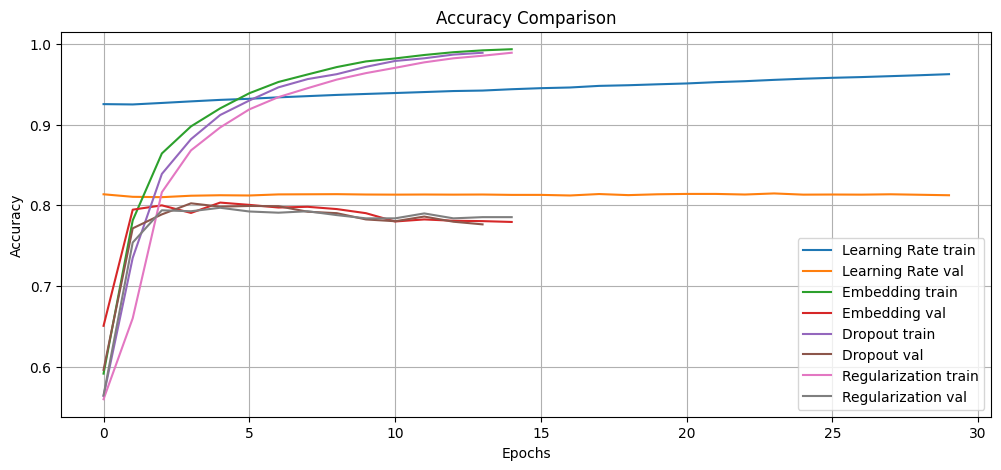

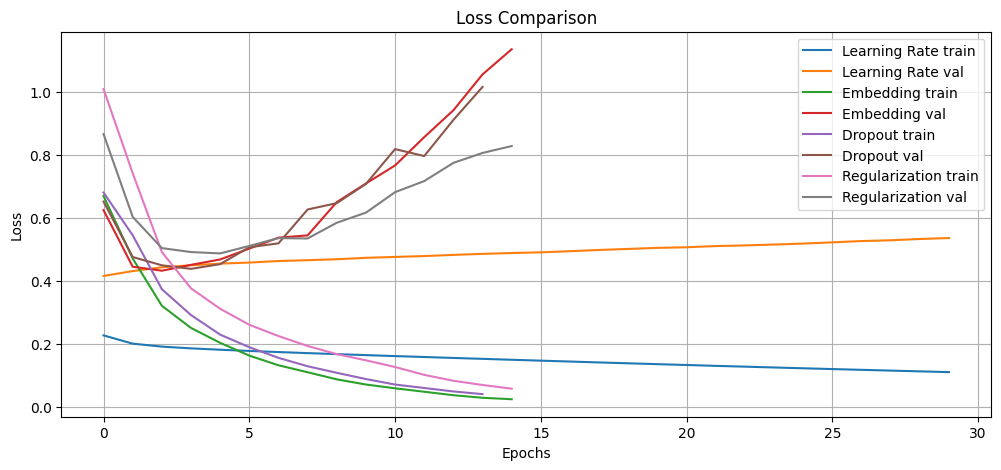

In [24]:
def plot_history(histories, metric='accuracy'):
    plt.figure(figsize=(12, 5))
    for name, history in histories.items():
        plt.plot(history.history[metric], label=f'{name} train')
        plt.plot(history.history[f'val_{metric}'], label=f'{name} val')
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.title(f'{metric.capitalize()} Comparison')
    plt.grid(True)
    plt.show()

histories = {
    'Learning Rate': history1,
    'Embedding': history2,
    'Dropout': history3,
    'Regularization': history4
}
plot_history(histories, 'accuracy')
plot_history(histories, 'loss')


## Making Prediction

In [19]:
sarcastic_sentences = [
    "Oh great, another Monday morning. Just what I needed.",
    "I absolutely love when my phone dies in the middle of an important call.",
    "Sure, I’d love to work overtime this weekend—for free.",
    "Because nothing screams fun like standing in line at the DMV.",
    "Of course the printer stops working right before the deadline.",
    "Wow, my internet just got slower—what a dream come true.",
    "Yay, traffic again! I was hoping I'd spend an hour going five miles.",
    "I totally didn't need sleep last night, thanks for asking.",
    "Love when the coffee machine breaks down at 8 a.m.",
    "Oh fantastic, spilled coffee on my shirt right before the meeting."
]

In [20]:
sequences1 = tokenizer.texts_to_sequences(sarcastic_sentences)
padded1 = pad_sequences(sequences1, maxlen=maxlen, padding="post", truncating="post")
print(model.predict(padded1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
[[0.6902054 ]
 [0.89970005]
 [0.82019246]
 [0.9378714 ]
 [0.8131977 ]
 [0.40691733]
 [0.92033774]
 [0.08801281]
 [0.930406  ]
 [0.93782896]]


In [21]:
non_sarcastic_sentences = [
    "The sky was clear and the weather was perfect for a walk.",
    "She enjoys reading historical fiction in her free time.",
    "He just started a new job as a software engineer.",
    "Granny baked cookies for the whole family.",
    "They are planning a trip to the mountains this winter.",
    "The team celebrated their victory with a party.",
    "The new restaurant downtown serves delicious sushi.",
    "I finally finished my TensorFlow project last night.",
    "They planted tomatoes and peppers in the garden.",
    "The dog wagged its tail when I came home."
]

In [22]:
sequences2 = tokenizer.texts_to_sequences(non_sarcastic_sentences)
padded2 = pad_sequences(sequences2, maxlen=maxlen, padding="post", truncating="post")
print(model.predict(padded2))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
[[0.8755574 ]
 [0.9619102 ]
 [0.93495136]
 [0.8269722 ]
 [0.9269511 ]
 [0.9055544 ]
 [0.22085579]
 [0.9229145 ]
 [0.9072048 ]
 [0.81692225]]


In [23]:
from keras.saving import save_model
save_model(model, '/content/drive/MyDrive/Sarcasm-Detector/sarcasm.keras')